<a href="https://colab.research.google.com/github/prakharjn/artg-twitter-sentiment/blob/master/ARTG_Maple_Project_2_Airlines_Tweets_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airlines Tweets Sentiment Analysis Using BERT

# ARTG Project - By Team Maple

### Step 0: Importing libraries

In [4]:
import pandas as pd
import numpy as np

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [16]:
from nltk import ngrams

In [8]:
import collections

In [9]:
from wordcloud import WordCloud,STOPWORDS

In [10]:
#step 3.1
from sklearn.model_selection import train_test_split

In [11]:
#step 4
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#Step 4.2
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

In [13]:
#Step 4.3
%%capture cup
!pip install simpletransformers==0.40.2

In [17]:
%%capture cup
!git clone https://github.com/NVIDIA/apex


In [ ]:
%cd apex
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

In [ ]:
#Step 4.3
#conda install -c pytorch pytorch

In [19]:
#Step 4.3
from simpletransformers.classification import ClassificationModel
import sklearn
import logging

### Step 1: Importing the Data + Initial Data Preprocessing

**<font color="blue">1.1 Importing data</font>**  

In [21]:
from google.colab import files
uploaded = files.upload()

Saving AirlineTweets.csv to AirlineTweets.csv


In [22]:
# Dataset is now stored in a Pandas Dataframe
import io
tweets = pd.read_csv(io.BytesIO(uploaded['AirlineTweets.csv']), header=0)


In [32]:
#@title Default title text
tweets.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


**<font color="blue">1.2 Initial Data Preprocessing</font>**  
**<font color="red">a. Reviewing missing data  <br />b. Removing redundant columns</font>**

In [23]:
#Taking a look at the dataframe
print("Shape of the dataframe is",tweets.shape)
print("The number of nulls in each column are \n", tweets.isna().sum())

Shape of the dataframe is (14640, 15)
The number of nulls in each column are 
 tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


In [24]:
#Removing irrelevant Null value columns
del tweets["negativereason"]
del tweets["negativereason_confidence"]
del tweets["airline_sentiment_gold"]
del tweets["negativereason_gold"]
del tweets["tweet_coord"]
del tweets["user_timezone"]
del tweets["tweet_location"]
tweets.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_created
0,570306133677760513,neutral,1.0000,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800
1,570301130888122368,positive,0.3486,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800
2,570301083672813571,neutral,0.6837,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800


**<font color="blue">1.3 Data Preprocessing for NLP</font>**  
**<font color="red">a. Cleaning tweets for characters and URL remenants<br />b. Lower casing<br />c. Removing Stopwords<br />d. Tokenization</font>**

In [25]:
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(tweet):
    text = re.sub(r"http:(\/\/t\.co\/([A-Za-z0-9]|[A-Za-z]){10})", "", tweet)
    only_letters = re.sub("[^a-zA-Z]", " ",text) 
    #tokens = nltk.word_tokenize(only_letters)[2:] #use this to delete airline name
    tokens = nltk.word_tokenize(only_letters)[:] #use this to include airline name
    lower_case = [l.lower() for l in tokens]
    #filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in lower_case]
    return ' '.join(lemmas)
   
def normalizer2(tweet):
    text = re.sub(r"http:(\/\/t\.co\/([A-Za-z0-9]|[A-Za-z]){10})", "", tweet)
    only_letters = re.sub("[^a-zA-Z]", " ",text) 
    tokens = nltk.word_tokenize(only_letters)[:] #including airline name
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas #return lemmas as tokens

In [26]:
tweets['normalized_tweet'] = tweets.text.apply(normalizer)
tweets['normalized_tweet_tokens'] = tweets.text.apply(normalizer2)

In [27]:
#pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
tweets[['text','normalized_tweet','normalized_tweet_tokens']].head()

,text,normalized_tweet,normalized_tweet_tokens
0,@VirginAmerica What @dhepburn said.,virginamerica what dhepburn said,"[virginamerica, dhepburn, said]"
1,@VirginAmerica plus you've added commercials t...,virginamerica plus you ve added commercial to ...,"[virginamerica, plus, added, commercial, exper..."
2,@VirginAmerica I didn't today... Must mean I n...,virginamerica i didn t today must mean i need ...,"[virginamerica, today, must, mean, need, take,..."
3,@VirginAmerica it's really aggressive to blast...,virginamerica it s really aggressive to blast ...,"[virginamerica, really, aggressive, blast, obn..."
4,@VirginAmerica and it's a really big bad thing...,virginamerica and it s a really big bad thing ...,"[virginamerica, really, big, bad, thing]"


### Step 2: Data Analysis and Visualizations

**<font color="blue">2.1 Counts of all Positive, Neutral, Negative tweets</font>**  

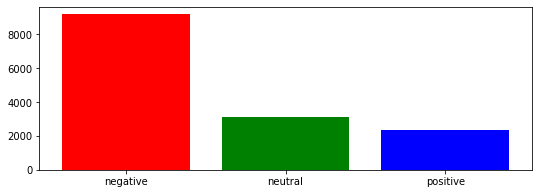

In [42]:
#Counts of positive, negative, neutral tweets
sentiment_counts = tweets.airline_sentiment.value_counts()
names = ['negative', 'neutral', 'positive']
plt.figure(figsize=(30, 3))
plt.subplot(131)
plt.bar(names, sentiment_counts.values, color=['red', 'green', 'blue'])
plt.show()

**<font color="blue">2.2 Count of tweets by Moods, by Airlines</font>**  

In [43]:
print("Total number of tweets for each airline \n ",
      tweets.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))

Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America    504 
Name: airline_sentiment, dtype: int64


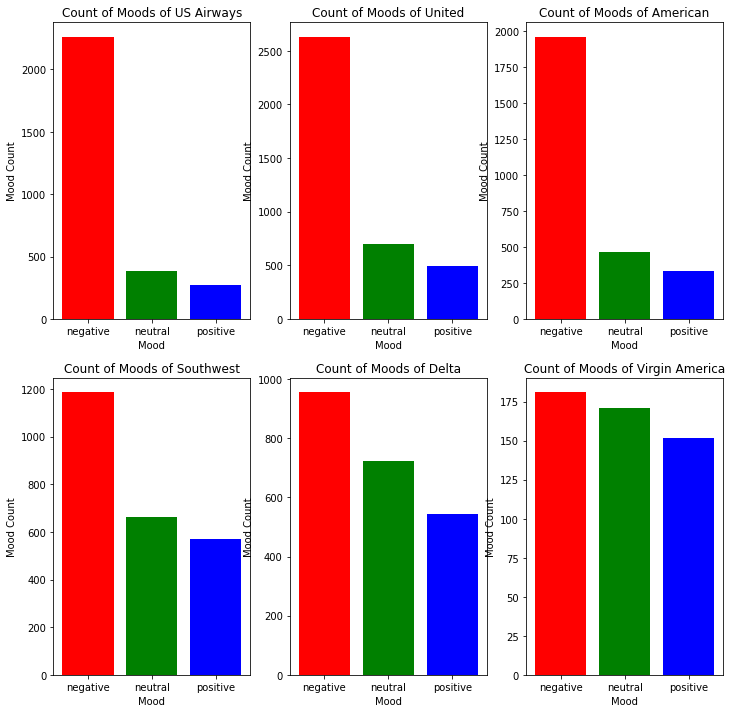

In [44]:
def plot_sub_sentiment(Airline):
    df=tweets[tweets['airline']==Airline]
    count=df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+Airline)
plt.figure(1,figsize=(12, 12))
plt.subplot(231)
plot_sub_sentiment('US Airways')
plt.subplot(232)
plot_sub_sentiment('United')
plt.subplot(233)
plot_sub_sentiment('American')
plt.subplot(234)
plot_sub_sentiment('Southwest')
plt.subplot(235)
plot_sub_sentiment('Delta')
plt.subplot(236)
plot_sub_sentiment('Virgin America')

**<font color="blue">2.3 Word Clouds of most used words in all positive and negative tweets</font>**  

Creating bigrams and trigrams

In [45]:
def ngrams(input_list):
    onegrams = input_list
    bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
    return bigrams+trigrams
tweets['grams'] = tweets.normalized_tweet_tokens.apply(ngrams)
tweets[['grams']].head()

,grams
0,"[virginamerica dhepburn, dhepburn said, virginamerica dhepburn said]"
1,"[virginamerica plus, plus added, added commercial, commercial experience, experience tacky, virginamerica plus added, plus added commercial, added commercial experience, commercial experience tacky]"
2,"[virginamerica today, today must, must mean, mean need, need take, take another, another trip, virginamerica today must, today must mean, must mean need, mean need take, need take another, take another trip]"
3,"[virginamerica really, really aggressive, aggressive blast, blast obnoxious, obnoxious entertainment, entertainment guest, guest face, face amp, amp little, little recourse, virginamerica really aggressive, really aggressive blast, aggressive blast obnoxious, blast obnoxious entertainment, obnoxious entertainment guest, entertainment guest face, guest face amp, face amp little, amp little recourse]"
4,"[virginamerica really, really big, big bad, bad thing, virginamerica really big, really big bad, big bad thing]"


Selecting top 50 words from each category

In [47]:
def count_words(input):
    cnt = collections.Counter()
    for row in input:
        for word in row:
            cnt[word] += 1
    return cnt

In [48]:
positivewords =tweets[(tweets.airline_sentiment == 'positive')][['grams']].apply(count_words)['grams'].most_common(50)
negativewords =tweets[(tweets.airline_sentiment == 'negative')][['grams']].apply(count_words)['grams'].most_common(50)
neutralwords  =tweets[(tweets.airline_sentiment == 'neutral')][['grams']].apply(count_words)['grams'].most_common(50)

In [49]:
def column(matrix, i):
    return [row[i] for row in matrix]

In [50]:
positiveword=' '.join(column(positivewords, 0))
negativeword=' '.join(column(negativewords, 0))
neutralword=' '.join(column(neutralwords, 0))

**<font color="red">2.3.1 Word Cloud of Positive Tweets</font>**

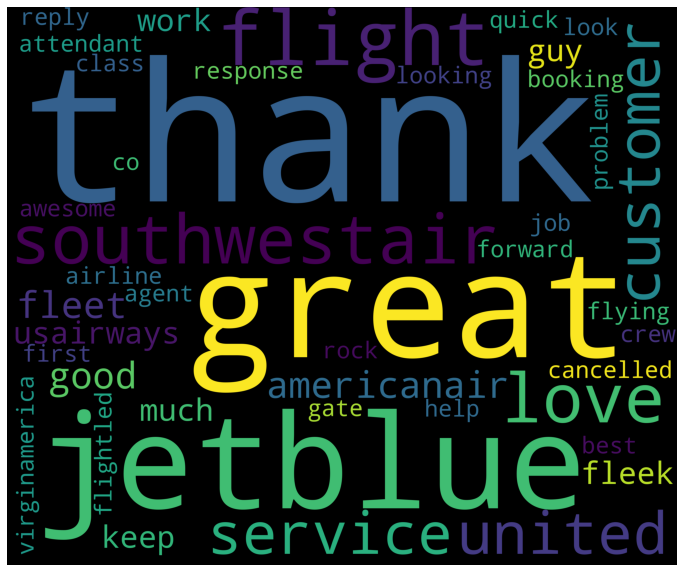

In [51]:
wordcloud  = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                      ).generate(positiveword)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**<font color="red">2.3.2 Word Cloud of Negative Tweets</font>**

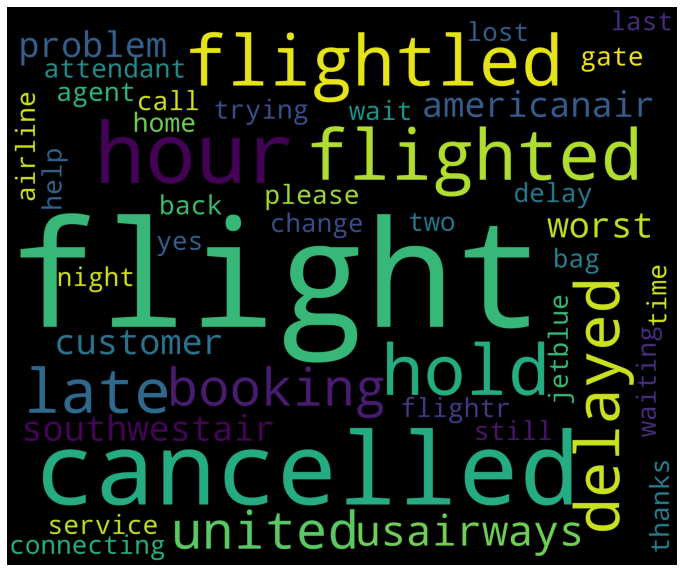

In [50]:
wordcloud2 = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                      ).generate(negativeword)
plt.figure(2,figsize=(12, 12))
plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

### Step 3: Creating Training and Test Data

**<font color="blue">3.1 Assiging target values to the sentiments</font>**  

In [52]:
def sentiment2target(sentiment):
    return {
        'negative': 0,
        'neutral': 1,
        'positive' : 2
    }[sentiment]
targets = tweets.airline_sentiment.apply(sentiment2target)

In [53]:
data_train, data_test, y_train, y_test = train_test_split(tweets.normalized_tweet, tweets.airline_sentiment, 
                                                          test_size=0.2, random_state=1)

**<font color="blue">3.2 Spliting the data</font>**  

In [54]:
traindf = pd.DataFrame(np.array(data_train), columns=["tweet"])
traindf["label"] = np.array(y_train)
devdf = pd.DataFrame(np.array(data_test), columns=["tweet"])
devdf["label"] = np.array(y_test)

In [55]:
traindf.head(5)

,tweet,label
0,united no wonder the cabin is filthy badservice,negative
1,southwestair you need to be more accommodating to your loyal customer not happy now,negative
2,jetblue you guy get rid of the hip hop station on sirius xm,neutral
3,americanair kid upset my staff upset one accused of stealing fruit mistreatment due to airline policy of an austic child,negative
4,united recent service have been very bad my nc trip wa aweful very disappointed and never again,negative


In [56]:
devdf.head(5)

,tweet,label
0,jetblue i ll pas along the advice you guy rock,positive
1,united i sent you a dm with my file reference number i just want to know if someone ha located my bag even if it s not here yet,negative
2,southwestair black history commercial is really sweet well done,positive
3,southwestair why am i still in baltimore delta is doing lap around u and laughing about it ridiculous,negative
4,southwestair sea to den south sound volleyball team on it way,positive


### Step 4: Creating Machine Learning classifiers

**<font color="blue">4.1 Assigning transformer weights equally</font>**  

In [57]:
union = FeatureUnion([ ("w_v2", TfidfVectorizer(analyzer = 'char', ngram_range=(1,5)  )),
                      ("w_v3", TfidfVectorizer(analyzer = 'char_wb', ngram_range=(1,5)  )),
                      ("w_v", CountVectorizer( ngram_range=(1,3),stop_words=None )),],
transformer_weights={
            'w_v': 1, 
        'w_v2': 1,   
           'w_v3': 1, 
           },)
X_train = union.fit_transform(data_train)
X_test = union.transform(data_test)
X_train.shape

(11712, 400275)

In [58]:
Accuracy=[]
F1=[]

**<font color="blue">4.2 Multinomial Naive Bayes (Baseline)</font>**  

In [59]:
model = make_pipeline( (MultinomialNB(alpha=0.03))).fit(X_train, y_train)
predicted = model.predict(X_test) 
score = metrics.accuracy_score(y_test, predicted)*100
Accuracy.append(score)
print("MultinomialNB accuracy:   %0.3f" % score) 

f1=f1_score(y_test, predicted, average='macro')*100
F1.append(f1)

print("MultinomialNB F1-score:   %0.3f" % f1) 
print()
print(classification_report(y_test, predicted))

MultinomialNB accuracy:   79.269
MultinomialNB F1-score:   72.558

              precision    recall  f1-score   support

    negative       0.85      0.90      0.87      1826
     neutral       0.65      0.54      0.59       611
    positive       0.72      0.71      0.72       491

    accuracy                           0.79      2928
   macro avg       0.74      0.72      0.73      2928
weighted avg       0.79      0.79      0.79      2928



**<font color="red">Confusion Matrix</font>**

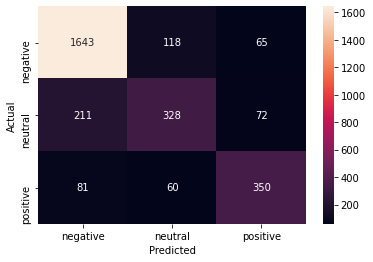

In [60]:
confusion_matrix = pd.crosstab(y_test, predicted, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='.0f')
plt.show()

**<font color="red">Use case for Prediction</font>**

In [61]:
#Type in text to check the prediction:
typeintext = 'i did not like my last flight'
typeintext = union.transform([typeintext])
print(model.predict(typeintext)[0])

negative


**<font color="red">What did the model misclassifiy?</font>**

In [62]:
y_test = np.array(y_test)
predicted = np.array(predicted)
data_test = np.array(data_test)

In [63]:
predictedprob = model.predict_proba(X_test) 
for i in range(len(predictedprob)):
    for j in range(len(predictedprob[i])):
        predictedprob[i][j] = '{0:.2f}'.format(predictedprob[i][j])
missclassified=[]
true=[]
prd=[]
prdprob=[]
other_prdprob=[]
for i in range(len(y_test)):
    if y_test[i] != predicted[i]:
        missclassified.append(data_test[i])
        true.append(str(y_test[i]))
        prd.append(str(predicted[i]))
        indx=np.argmax(predictedprob[i])
        prdprob.append(str(predictedprob[i][indx]))
        other_prdprob.append(str(predictedprob[i]))
miss = pd.DataFrame(missclassified,columns=["sentence"])
miss["True"] = true
miss["Predicated"] = prd
miss["Confidance"] = prdprob
miss["All_prob"] = other_prdprob

In [64]:
pd.set_option('display.max_colwidth',1)
miss.head(20)

,sentence,True,Predicated,Confidance,All_prob
0,americanair seat that were assigned are inappropriate for child this age aa knew age of child,negative,neutral,0.83,[0.17 0.83 0. ]
1,americanair epicfail on connection in chicago today extremely disappointed w unaccommodating customer service rethinking loyalty,neutral,negative,1.0,[1. 0. 0.]
2,jetblue time to reevaluate my nyc carrier,negative,positive,0.65,[0.2 0.14 0.65]
3,usairways i just hope that pilot had a good day off,neutral,negative,1.0,[1. 0. 0.]
4,americanair travel week delay cancelled flightlations if you want to learn more about the merger press delay my connector in chicago deice,neutral,negative,1.0,[1. 0. 0.]
5,americanair again no special meal catered for me in f jfk lax thankfully i m on qantas the rest of way i fear what youd not cater on that,negative,positive,0.84,[0.13 0.03 0.84]
6,united wa on nh on united ticket rerouted to iad due to weather in jfk can you get u home on united or,neutral,negative,1.0,[1. 0. 0.]
7,americanair hi there flight from dallas just cancelled flightled going to la can u pls help rebook me,negative,neutral,0.94,[0.06 0.94 0. ]
8,united even though technically after i land i will be silver,neutral,negative,0.88,[0.88 0.12 0. ]
9,jetblue s ceo battle to appease passenger and wall street thevdt,negative,neutral,1.0,[0. 1. 0.]


**<font color="red">The above dataframe shows misclassified sentences that was made by the Multinomial Naive Bayes classifier.</font>**
 - When we manually check the misclassified sentences vs their prediction, we can tell that the given labels are incorrect in some cases.
 - Also, our model can not detect when text is sarcastic (i.e. tweets that are negative but contain positive words), such tweets might be misclassified by our model.

**<font color="blue">4.3 Linear Regression (Baseline)</font>**  

In [86]:
data_train, data_test, y_train, y_test = train_test_split(tweets.normalized_tweet, targets, test_size=0.2, random_state=1)

In [87]:
#convert the labels to one hot encoder 
a = y_train
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1
b


array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [88]:
#one-vs-all explicitly
model11 = make_pipeline( (LinearRegression())).fit(X_train, column(b, 0))
predicted11 = model11.predict(X_test) 

model22 = make_pipeline( (LinearRegression())).fit(X_train, column(b, 1))
predicted22 = model22.predict(X_test) 

model33 = make_pipeline( (LinearRegression())).fit(X_train, column(b, 2))
predicted33 = model33.predict(X_test) 

LinearRegression_preds = np.stack((predicted11, predicted22,predicted33), axis=-1)

In [89]:
preds_LinearRegression =[]
for i in LinearRegression_preds:
    preds_LinearRegression.append(np.argmax(i))

score = metrics.accuracy_score(y_test, preds_LinearRegression)*100
Accuracy.append(score)
print("LinearRegression accuracy:   %0.3f" % score) 
f1=f1_score(y_test, preds_LinearRegression, average='macro')*100
F1.append(f1)

print("LinearRegression F1-score:   %0.3f" % f1) 
print()
print(classification_report(y_test, preds_LinearRegression))

LinearRegression accuracy:   78.996
LinearRegression F1-score:   72.771

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1826
           1       0.61      0.59      0.60       611
           2       0.75      0.67      0.71       491

    accuracy                           0.79      2928
   macro avg       0.74      0.72      0.73      2928
weighted avg       0.79      0.79      0.79      2928



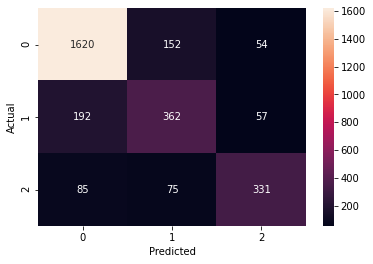

In [90]:
confusion_matrix = pd.crosstab(np.array(y_test), np.array(preds_LinearRegression), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='.0f')
plt.show()

**<font color="blue">4.4 BERT</font>**  

BERT while being a as a heavy model, most of the time outperformes machine learning models.
So we expect better results using BERT and we will use its prediction to train a machine learning model.

In [69]:
data_train, data_test, y_train, y_test = train_test_split(tweets.normalized_tweet, targets, test_size=0.2, random_state=1)
traindf = pd.DataFrame(np.array(data_train), columns=["tweet"])
traindf["label"] = np.array(y_train)
devdf = pd.DataFrame(np.array(data_test), columns=["tweet"])
devdf["label"] = np.array(y_test)

In [70]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [71]:
# Create a ClassificationModel
bertmodel = ClassificationModel('bert', 'bert-base-cased', num_labels=3, use_cuda=True, cuda_device=0, 
                            args={
    'reprocess_input_data': True,
    "learning_rate": 4e-5,
    'overwrite_output_dir': True,
    'num_train_epochs': 3,    "save_eval_checkpoints": False,
    "save_steps": -1,}
    )
print(traindf.head())

INFO:filelock:Lock 140002852378720 acquired on /root/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391.lock


INFO:filelock:Lock 140002852378720 released on /root/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391.lock


INFO:filelock:Lock 140002839120640 acquired on /root/.cache/torch/transformers/d8f11f061e407be64c4d5d7867ee61d1465263e24085cfa26abf183fdc830569.3fadbea36527ae472139fe84cddaa65454d7429f12d543d80bfc3ad70de55ac2.lock


INFO:filelock:Lock 140002839120640 released on /root/.cache/torch/transformers/d8f11f061e407be64c4d5d7867ee61d1465263e24085cfa26abf183fdc830569.3fadbea36527ae472139fe84cddaa65454d7429f12d543d80bfc3ad70de55ac2.lock


- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:filelock:Lock 140002844833048 acquired on /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1.lock


INFO:filelock:Lock 140002844833048 released on /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1.lock



                                                                                                                      tweet  label
0  united no wonder the cabin is filthy badservice                                                                           0    
1  southwestair you need to be more accommodating to your loyal customer not happy now                                       0    
2  jetblue you guy get rid of the hip hop station on sirius xm                                                               1    
3  americanair kid upset my staff upset one accused of stealing fruit mistreatment due to airline policy of an austic child  0    
4  united recent service have been very bad my nc trip wa aweful very disappointed and never again                           0    


In [72]:
# Train the bertmodel
bertmodel.train_model(traindf, eval_df=devdf, args={'reprocess_input_data': True})

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:270: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 1.241701

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 1.103435Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 0.947721

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.604202Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Running loss: 0.228406


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.469584Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Running loss: 0.021288


Running loss: 0.544704



INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.


In [73]:
predictions, raw_outputs = bertmodel.predict(np.array(data_test))

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


In [74]:
from sklearn.metrics import f1_score,classification_report
f1_score(y_true=np.array(y_test), y_pred=predictions, average='micro')
F1.append(f1)

In [75]:
score = metrics.accuracy_score(np.array(y_test), predictions)*100
Accuracy.append(score)

In [76]:
print(classification_report(np.array(y_test),predictions, labels=None))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1826
           1       0.69      0.66      0.68       611
           2       0.79      0.77      0.78       491

    accuracy                           0.84      2928
   macro avg       0.79      0.78      0.79      2928
weighted avg       0.84      0.84      0.84      2928



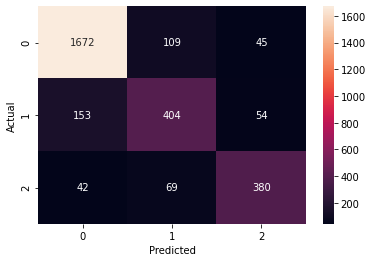

In [77]:
confusion_matrix = pd.crosstab(np.array(y_test),predictions, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='.0f')
plt.show()

In [78]:
b=[]
for i in y_test:
    if i==2:
        b.append("positive")
    elif i == 0:
        b.append("negative")
    else:
        b.append("neutral")

In [79]:
#what did the model misclassifiy
data_test = np.array(data_test)
predictedprob = raw_outputs
for i in range(len(predictedprob)):
    for j in range(len(predictedprob[i])):
        predictedprob[i][j] = '{0:.2f}'.format(predictedprob[i][j])
missclassified=[]
true=[]
prd=[]
prdprob=[]
other_prdprob=[]
for i in range(len(b)):
    if b[i] != predicted[i]:
        missclassified.append(data_test[i])
        true.append(str(b[i]))
        prd.append(str(predicted[i]))
        indx=np.argmax(predictedprob[i])
        prdprob.append(str(predictedprob[i][indx]))
        other_prdprob.append(str(predictedprob[i]))
miss = pd.DataFrame(missclassified,columns=["sentence"])
miss["True"] = true
miss["Predicated"] = prd
miss["Confidance"] = prdprob
miss["All_prob"] = other_prdprob

In [80]:
miss.head(20)

,sentence,True,Predicated,Confidance,All_prob
0,americanair seat that were assigned are inappropriate for child this age aa knew age of child,negative,neutral,4.59,[ 4.59 -1.25 -4.32]
1,americanair epicfail on connection in chicago today extremely disappointed w unaccommodating customer service rethinking loyalty,neutral,negative,5.0,[ 5. -2.25 -3.69]
2,jetblue time to reevaluate my nyc carrier,negative,positive,1.92,[ 0.27 1.92 -2.66]
3,usairways i just hope that pilot had a good day off,neutral,negative,3.45,[-1.32 -1.37 3.45]
4,americanair travel week delay cancelled flightlations if you want to learn more about the merger press delay my connector in chicago deice,neutral,negative,4.97,[ 4.97 -1.99 -3.89]
5,americanair again no special meal catered for me in f jfk lax thankfully i m on qantas the rest of way i fear what youd not cater on that,negative,positive,4.46,[ 4.46 -1.67 -3.85]
6,united wa on nh on united ticket rerouted to iad due to weather in jfk can you get u home on united or,neutral,negative,4.22,[-1.57 4.22 -2.81]
7,americanair hi there flight from dallas just cancelled flightled going to la can u pls help rebook me,negative,neutral,4.45,[-2.25 4.45 -2.24]
8,united even though technically after i land i will be silver,neutral,negative,2.38,[-1.31 2.38 -1.59]
9,jetblue s ceo battle to appease passenger and wall street thevdt,negative,neutral,3.56,[-2.27 3.56 -1.69]


**<font color="blue">4.5 DistilBert LinearRegression trained on BERT</font>**  

In [81]:
predictions_train, raw_outputs_train = bertmodel.predict(np.array(data_train))

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


In [82]:
model1 = make_pipeline( (LinearRegression())).fit(X_train, column(raw_outputs_train, 0))
predicted1 = model1.predict(X_test) 

model2 = make_pipeline( (LinearRegression())).fit(X_train, column(raw_outputs_train, 1))
predicted2 = model2.predict(X_test) 

model3 = make_pipeline( (LinearRegression())).fit(X_train, column(raw_outputs_train, 2))
predicted3 = model3.predict(X_test) 

In [83]:
knowledge_distil_preds = np.stack((predicted1, predicted2,predicted3), axis=-1)
preds_knowlsge_ditil =[]
for i in knowledge_distil_preds:
    preds_knowlsge_ditil.append(np.argmax(i))

In [84]:
score = metrics.accuracy_score(y_test, preds_knowlsge_ditil)*100
Accuracy.append(score)
print("Knowledge distilation accuracy:   %0.3f" % score) 
f1=f1_score(y_test, preds_knowlsge_ditil, average='macro')*100
print("Knowledge distilation F1-score:   %0.3f" % f1) 
F1.append(f1)

Knowledge distilation accuracy:   80.567
Knowledge distilation F1-score:   74.699


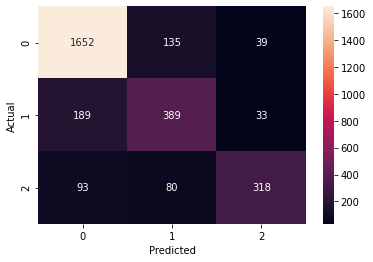

In [85]:
confusion_matrix = pd.crosstab(np.array(y_test),np.array(preds_knowlsge_ditil), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='.0f')
plt.show()

### Step 5: Comparing all models

Text(0.5, 1.0, 'Accuracies of Models')

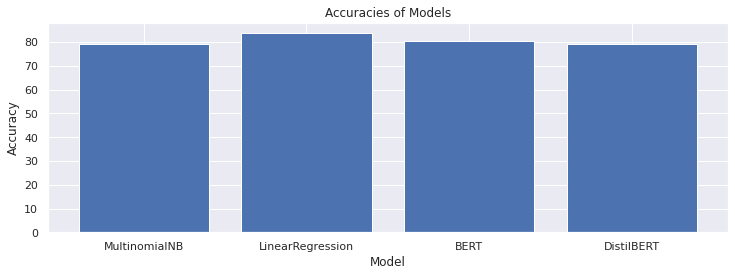

In [96]:
Index = [1,2,3,4]
sns.set()
plt.subplots(figsize=(20,4),tight_layout=True)
plt.subplot(1,2,1)
plt.bar(Index,Accuracy)
plt.xticks(Index, ["MultinomialNB","LinearRegression","BERT","DistilBERT"],rotation=0)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')


In [97]:
time_taken=[]

In [98]:
#count time to predict 1000 sentences:
import time
start_time = time.time()

sent = union.transform(data_test[:1000])
model.predict(sent)

print("MultinomialNB --- %s seconds ---" % (time.time() - start_time))
time_taken.append((time.time() - start_time))

MultinomialNB --- 0.6003282070159912 seconds ---


In [99]:
#count time to predict 1000 sentences:
start_time = time.time()

sent = union.transform(data_test[:1000])
predicted11 = model11.predict(sent) 
predicted22 = model22.predict(sent) 
predicted33 = model33.predict(sent) 
LinearRegression_preds = np.stack((predicted11, predicted22,predicted33), axis=-1)
preds_LinearRegression =[]
for i in LinearRegression_preds:
    preds_LinearRegression.append(np.argmax(i))

print("LinearRegression --- %s seconds ---" % (time.time() - start_time))
time_taken.append((time.time() - start_time))

LinearRegression --- 0.5707979202270508 seconds ---


In [100]:
#count time to predict 1000 sentences:
start_time = time.time()

bertmodel.predict(np.array(data_test[:1000]))

print("BERT --- %s seconds ---" % (time.time() - start_time))
time_taken.append((time.time() - start_time))

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.



BERT --- 3.2368245124816895 seconds ---


In [101]:
#count time to predict 1000 sentences:
start_time = time.time()
sent = union.transform(data_test[:1000])

predicted1 = model1.predict(sent) 
predicted2 = model2.predict(sent) 
predicted3 = model3.predict(sent) 
LinearRegression_preds = np.stack((predicted1, predicted2,predicted3), axis=-1)
preds_LinearRegression =[]
for i in LinearRegression_preds:
    preds_LinearRegression.append(np.argmax(i))

print("BERT_distil --- %s seconds ---" % (time.time() - start_time))
time_taken.append((time.time() - start_time))

BERT_distil --- 0.5771832466125488 seconds ---


Text(0.5, 1.0, 'Time taken to Predict 1000 sentence')

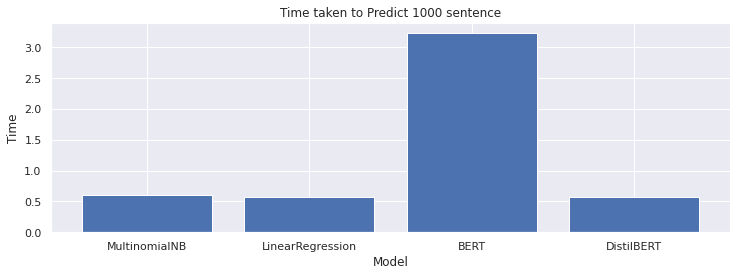

In [102]:
Index = [1,2,3,4]
sns.set()
plt.subplots(figsize=(20,4),tight_layout=True)
plt.subplot(1,2,1)
plt.bar(Index,time_taken)
plt.xticks(Index, ["MultinomialNB","LinearRegression","BERT","DistilBERT"],rotation=0)
plt.ylabel('Time')
plt.xlabel('Model')
plt.title('Time taken to Predict 1000 sentence')

Text(0.5, 1.0, 'F1-Score of Models')

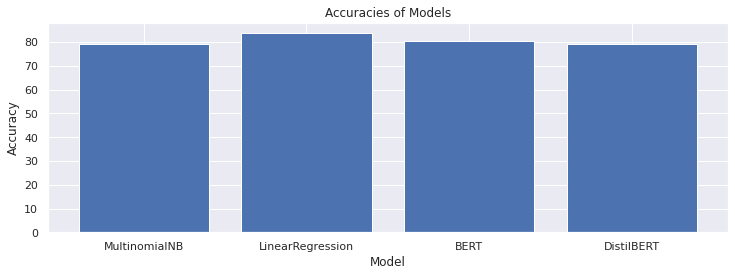

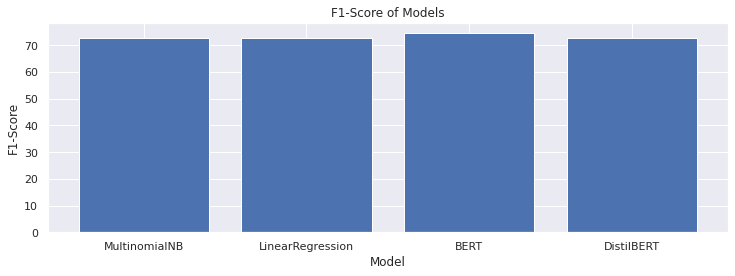

In [103]:
Index = [1,2,3,4]
sns.set()
plt.subplots(figsize=(20,4),tight_layout=True)
plt.subplot(1,2,1)
plt.bar(Index,Accuracy)
plt.xticks(Index, ["MultinomialNB","LinearRegression","BERT","DistilBERT"],rotation=0)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')

Index = [1,2,3,4]
sns.set()
plt.subplots(figsize=(20,4),tight_layout=True)
plt.subplot(1,2,1)
plt.bar(Index,F1)
plt.xticks(Index, ["MultinomialNB","LinearRegression","BERT","DistilBERT"],rotation=0)
plt.ylabel('F1-Score')
plt.xlabel('Model')
plt.title('F1-Score of Models')

### Step 5: Conclusion

**<font color="brown"> We began by using the tradiational machine learning models which achieved decent results</font>** **<font color="green"> (MultinomialNB, with accuracy: 79.269%, F1-score: 72.558%)</font>** **<font color="brown">. Then we used Google' BERT pre-trained model, which achieved better results, but the main model was heavy to train and took longer predciton times. To take advantage of both the high accuracy from BERT and the speed from machine learning models, we trained a </font>** **<font color="green"> Linear Regression model on BERT's predictions (inspired by DistilBERT)</font>** **<font color="brown">. This model achieived </font>** **<font color="green"> accuracy: 80.567%  and, F1-score: 74.699% </font>** **<font color="brown"> and maintained the same speed as machine learning models to make a prediciton.</font>**
